In [1]:
import datetime
from datetime import timedelta
from collections import OrderedDict

import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool

(180, 360)


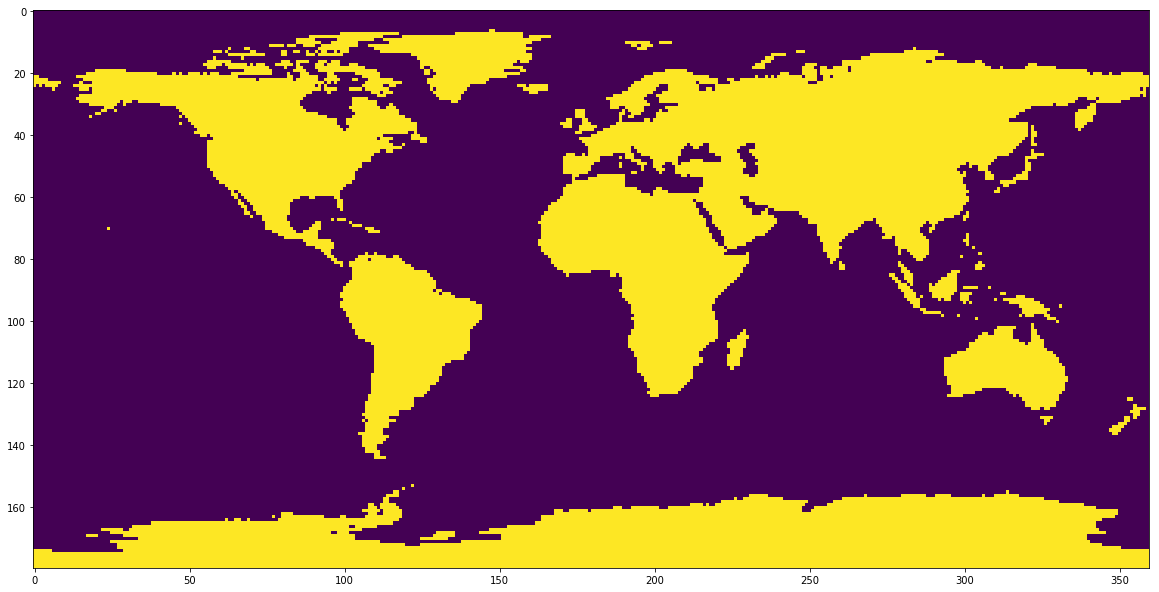

In [54]:
import cv2
a = cv2.imread("/home/nama/Desktop/worldmap.png")
a = cv2.resize(a, (360,180))
a = cv2.cvtColor(a, cv2.COLOR_BGR2HSV)
a = np.where(a[:,:,0]>90, 0, 1)
print(a.shape)
plt.figure(figsize=(20,20)); plt.imshow(a)

In [2]:
files = glob("data/AIS/*")
files = sorted([file for file in files if not '~' in file])

In [3]:
def preformat(df):
    df["T"] = df["DateTime"].map(
        lambda x: x.split(' ')[0] if not x == '-' else x)
    return df

In [4]:
# 列にもともと'-'が混ざっていると、dtypeが'object'に固定される?のであとから。
def preformat_mini(df):
    df['Cos'] = df["Course over ground"].map(
        lambda x: float(np.cos(float(x)/180.*np.pi)) if not x == '-' else x)
    df['Sin'] = df["Course over ground"].map(
        lambda x: float(np.sin(float(x)/180.*np.pi)) if not x == '-' else x)
    df["Y"] = df["Lat"].map(
        lambda x: x+90 if not x == '-' else x)
    df["X"] = df["Lng"].map(
        lambda x: x+180 if not x == '-' else x)
    df["Speed"] = df["Speed over ground"].map(
        lambda x: float(x)/20. if not x == '-' else x)
    df["DWT"] = df["DWT"].map(
        lambda x: float(x)/300000. if not x == '-' else x)
    df = df[['T', 'X', 'Y', 'Cos', 'Sin', 'Speed', 'DWT']]
    return df

In [5]:
start_date = datetime.datetime(2016,1,1)
day_count = 960
days = []
for single_date in (start_date + timedelta(n) for n in range(day_count)):
    days.append(
        str(single_date.year)
        +"/"+"{:02}".format(single_date.month)
        +"/"+"{:02}".format(single_date.day))
date = OrderedDict(zip(days, [None]*day_count))

In [6]:
def f(file):
    df = pd.read_csv(file, low_memory=False) # str'-'とfloatが混在している問題
    df = preformat(df)
    
    if len(df) == 0:
        print("error1", file)
        return
    
    data = {}
    key = None
    
    for t in list(date.keys()):
        temp = np.where(np.array(list(df['T'])) == t)[0].tolist()
        
        if not temp == []:
            _df = df[temp[0]:temp[-1]+1].copy()
            _df = preformat_mini(_df)
            mean = _df.mean() # 'T' は消える
            
            if _df['X'].max() - _df['X'].min() > 180:
                _df["X"] = _df["X"].map(
                    lambda x: (lambda x: x+360 if x<180 else x)(x) if not x == '-' else x)
                _X = _df['X'].mean()
                if _X > 360:
                    _X -= 360
                mean['X'] = _X
            
            data[t] = mean
            
    if len(data) == 0:
        print("error2", file)
        return
    
    pd.DataFrame.from_dict(data).T.to_csv(
        "data/AIS_clean/"+file.split('/')[-1])

In [7]:
pool = Pool(processes=8)

with tqdm(total=len(files)) as t:
    for _ in pool.imap_unordered(f, files):
        t.update(1)

  5%|▌         | 48/934 [03:12<44:45,  3.03s/it]  

error2 data/AIS/fix_ais_bulk_9064889.csv


 85%|████████▍ | 793/934 [59:27<11:25,  4.87s/it]  

error1 data/AIS/fix_ais_bulk_9724843.csv
error1 data/AIS/fix_ais_bulk_9724855.csv


 98%|█████████▊| 919/934 [1:06:09<00:28,  1.91s/it]

error2 data/AIS/fix_ais_bulk_9806897.csv


100%|██████████| 934/934 [1:06:13<00:00,  3.51it/s]
